# Global (Imports, Constants, Utils etc) 



## GPU type

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 13 01:31:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 32%   36C    P8    18W / 170W |    745MiB / 12045MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module & Goggle Drive import

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
except:
  pass

In [ ]:
import os
import sys
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)

from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences    
)

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer



## Constant definision

In [ ]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)


OUTPUT_DATA_COLUMNS = ["position_x", "position_y", "position_z"]
TIMESTAMP_COLUMNS = [
    "motor_state_timestamp",
    "barometer_timestamp",
    "magnetometer_timestamp",
    "rotor_timestamp"
]


INPUT_SEQUENCE_COLUMNS = ["angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", 
                          "barometer_qnh", 
                          "barometer_timestamp",                          
                          "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                          "magnetometer_magnetic_field_body_z", "magnetometer_timestamp",
                          "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                          "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                          "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                          "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                          "rotor_timestamp"
                         ]

ACCELOMETER_SENSORS = ["angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z"]
ORIENTATION_SENSORS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
MAGNOMETER_SENSORS = ["magnetometer_magnetic_field_body_x", 
                      "magnetometer_magnetic_field_body_y",
                      "magnetometer_magnetic_field_body_z"]
BAROMETER_SENSORS = ["barometer_altitude", "barometer_pressure", "barometer_qnh"]
ROTOR_SENSORS = ["rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                 "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                 "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                 "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler"]

OUTPUT_SEQUENCE_COLUMNS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z"]

MAIN_TIMESTAMP_COLUMN = "motor_state_timestamp"
INPUT_SEQUENCE_LENGTH = 10


In [ ]:
def get_recordings_files():
    all_csv_files = os.listdir(DATA_FOLDER_PATH)

    # Orders the "manual" files to the end (They are more likely represent 
    # the test user). So this data should be used as test
    auto_genereted_flights = [recording_file for recording_file in all_csv_files 
                              if not recording_file.startswith("manual")]
    manual_generated_flights = [recording_file for recording_file in all_csv_files 
                              if recording_file.startswith("manual")]

    all_csv_files = []
    all_csv_files.extend(auto_genereted_flights)
    all_csv_files.extend(manual_generated_flights)

    return all_csv_files


In [ ]:
# Set float 64
tf.keras.backend.set_floatx('float32')

## Utils


### Save and Load models

In [ ]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

## Data Split

In [ ]:
def split_data(data: np.array, train_per = 0.95, dev_per= 0.5):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(train_per * data_len),
                                       int((dev_per + train_per) * data_len)])

    return train, dev, test


### Shuffle dataset

In [ ]:
def shuffle_data_set(x_data: np.array, y_data: np.array):
    example_amount = x_data.shape[0]
    shuffle_indexes = np.random.permutation(example_amount)
    
    x_data = x_data[shuffle_indexes]
    y_data = y_data[shuffle_indexes]

    return x_data, y_data

# Data Preprocessing

### Load data

In [ ]:
# Loads data from recording file
# Converts timestamp -> time offset from last timestamp
#          location  -> step made from last location in x time offset

def _convert_timestamp_to_interval_seconds(flight_input_df: pd.DataFrame, timestamp_columns: list):
    """
    Converts the timestamp fields into the amount of seconds between each two timestamps

    Note: each timestamp represents the amount eof NANO seconds (1,000,000,000 nanoseconds = 1 seconds)
    """
    # Converts the start time to time interval
    next_time_df = flight_input_df[timestamp_columns].shift(-1)
    time_diff_df = (next_time_df - flight_input_df[timestamp_columns]) / 1_000_000_000
    flight_input_df.loc[:, timestamp_columns] = time_diff_df
    return flight_input_df

def _convert_speed_to_step(flight_output_df: pd.DataFrame):
    next_speed_df = flight_output_df.shift(-1)
    speed_diff = flight_output_df - next_speed_df

    return speed_diff
    
def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)

    x_df = flight_df[input_columns].copy()
    timestamp_columns = [column for column in input_columns if column in TIMESTAMP_COLUMNS]
    x_df = _convert_timestamp_to_interval_seconds(x_df, timestamp_columns)

    y_df = flight_df[output_columns].copy()
    y_df = _convert_speed_to_step(y_df)
    
    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    return x_df, y_df

In [ ]:
def load_dataset(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df)
            y_sessions.append(y_df)

        except ValueError as error:
            print(str(error))

    x_df = pd.concat(x_sessions, ignore_index=True)
    y_df = pd.concat(y_sessions, ignore_index=True)

    return x_df, y_df


### Feature Analysis

In [ ]:
x_df, y_df = load_dataset(INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS)

#### Initial feature analysis

In [ ]:
print(x_df.head())
print(y_df.head())

   angular_acceleration_x  angular_acceleration_y  angular_acceleration_z  \
0                0.064222                0.097211                0.000205   
1               13.786359               28.990995                0.000068   
2                5.067631               13.179457               -0.009419   
3               -8.836759              -14.463119               -0.007767   
4               -1.474992               -9.003764                0.000245   

   linear_acceleration_x  linear_acceleration_y  linear_acceleration_z  \
0               0.761814               0.007991               0.013129   
1               0.280336              -0.002944               6.169969   
2               0.098804              -0.002084               8.432880   
3               0.079885              -0.001000               8.525730   
4               0.061037              -0.001278               8.675733   

   angular_velocity_x  angular_velocity_y  angular_velocity_z  orientation_x  \
0           

#### X Value Analysis

In [ ]:
print(x_df[MAGNOMETER_SENSORS].describe())

       magnetometer_magnetic_field_body_x  magnetometer_magnetic_field_body_y  \
count                       644793.000000                       644793.000000   
mean                             0.219767                            0.021246   
std                              0.101975                            0.094896   
min                             -0.424579                           -0.408155   
25%                              0.228409                           -0.022197   
50%                              0.247151                            0.028382   
75%                              0.255205                            0.064349   
max                              0.430034                            0.417823   

       magnetometer_magnetic_field_body_z  
count                       644793.000000  
mean                             0.357723  
std                              0.040765  
min                              0.071483  
25%                              0.357859  
50%   

In [ ]:
print(x_df[BAROMETER_SENSORS].describe())

       barometer_altitude  barometer_pressure  barometer_qnh
count       644793.000000       644793.000000      644793.00
mean           230.200958        98590.065986        1013.25
std             46.540025          547.696207           0.00
min            121.108429        97475.968750        1013.25
25%            202.444244        98222.539062        1013.25
50%            237.003632        98508.914062        1013.25
75%            261.408600        98915.531250        1013.25
max            325.311523        99877.945312        1013.25


In [ ]:
print(x_df[ROTOR_SENSORS].describe())

       rotor_a_speed  rotor_a_thrust  rotor_a_torque_scaler  rotor_b_speed  \
count  644793.000000   644793.000000          644793.000000  644793.000000   
mean      521.514874        2.619357              -0.034822     521.536908   
std        96.118645        0.853724               0.011350      96.098152   
min         0.000000        0.000000              -0.055562       0.000000   
25%       508.611603        2.409497              -0.038395     508.589478   
50%       519.939331        2.518020              -0.033475     519.930969   
75%       556.837769        2.888093              -0.032032     556.785461   
max       669.857422        4.179445              -0.000000     669.857422   

       rotor_b_thrust  rotor_b_torque_scaler  rotor_c_speed  rotor_c_thrust  \
count   644793.000000          644793.000000  644793.000000   644793.000000   
mean         2.619535              -0.034824     521.488767        2.619397   
std          0.853292               0.011344      96.282521 

In [ ]:
print(x_df.describe())

       angular_acceleration_x  angular_acceleration_y  angular_acceleration_z  \
count           644793.000000           644793.000000            6.447930e+05   
mean                 0.001161                0.001003           -7.483015e-05   
std                  4.782055                5.101645            3.662470e-01   
min               -176.860291             -146.200256           -7.453093e+00   
25%                 -0.014712               -0.010956           -7.660215e-07   
50%                  0.000000                0.000000            0.000000e+00   
75%                  0.014162                0.013619            7.826566e-07   
max                187.232956              153.368286            7.200834e+00   

       linear_acceleration_x  linear_acceleration_y  linear_acceleration_z  \
count          644793.000000          644793.000000          644793.000000   
mean               -0.002643               0.001318               0.007685   
std                 1.602116        

#### Target Value analysis

In [ ]:
print(y_df.describe())

       linear_velocity_x  linear_velocity_y  linear_velocity_z
count      644793.000000      644793.000000      644793.000000
mean            0.000041          -0.000021          -0.000060
std             0.025968           0.027137           0.043930
min            -0.641280          -0.286550          -0.257565
25%            -0.000208          -0.000214          -0.001146
50%             0.000000           0.000000           0.000000
75%             0.000272           0.000284           0.002000
max             0.240338           0.459803           8.092052


(644793, 3)


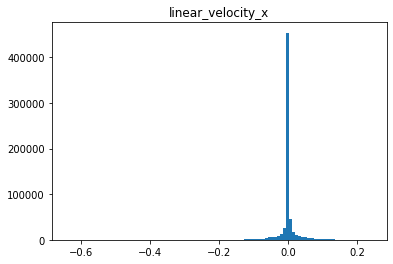

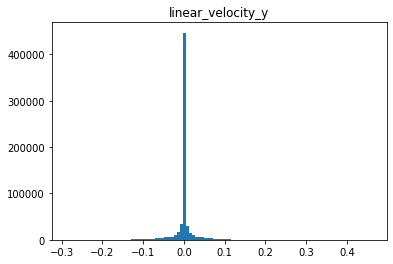

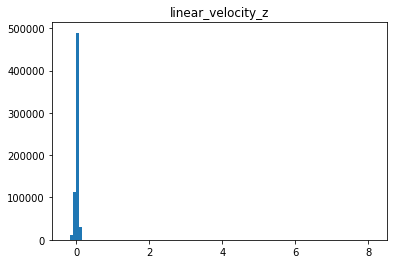

In [ ]:
bins = 100

print(y_df.shape)

output = plt.hist(y_df["linear_velocity_x"], bins=bins)
plt.title('linear_velocity_x');
plt.show()

output = plt.hist(y_df["linear_velocity_y"], bins=bins)
plt.title('linear_velocity_y');
plt.show()

output = plt.hist(y_df["linear_velocity_z"], bins=bins)
plt.title('linear_velocity_z');
plt.show()

In [ ]:
# There are many outliers, most of the data is distributed ebove zero
# Removes outliers
valid_indexes = (np.abs(stats.zscore(y_df)) < 10).all(axis=1)
x_df = x_df[valid_indexes]
y_df = y_df[valid_indexes]

(644777, 3)


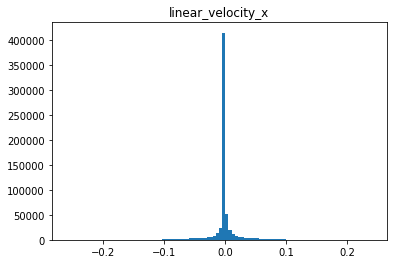

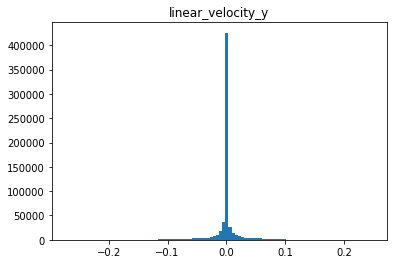

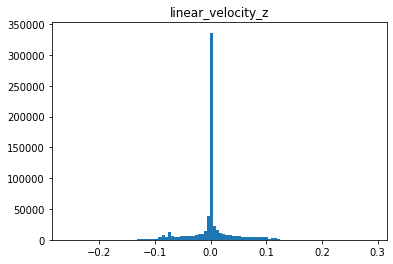

In [ ]:
bins = 100

print(y_df.shape)

output = plt.hist(y_df["linear_velocity_x"], bins=bins)
plt.title('linear_velocity_x');
plt.show()

output = plt.hist(y_df["linear_velocity_y"], bins=bins)
plt.title('linear_velocity_y');
plt.show()

output = plt.hist(y_df["linear_velocity_z"], bins=bins)
plt.title('linear_velocity_z');
plt.show()

In [ ]:
# print(x_df.dtypes)
# print()
# print(y_df.dtypes)

In [ ]:
# plt.figure(figsize=(20,15))
# sns.heatmap(x_df.corr(),annot=True);

### Preprocess data

In [ ]:
def preprocess_ann_dataset(x_df: pd.DataFrame, y_df : pd.DataFrame):
    # Removes target outliers
    print(f"shape before outlier remuval: {y_df.to_numpy().shape}")
    # valid_indexes = (np.abs(stats.zscore(y_df)) <  5).all(axis=1)
    # x_df = x_df[valid_indexes]
    # y_df = y_df[valid_indexes]
    print(f"shape after outlier remuval: {y_df.to_numpy().shape}")

    scaler_x = ColumnTransformer([
          ("rotor_sensors", StandardScaler(), ["rotor_a_speed", "rotor_b_speed",
                                            "rotor_c_speed", "rotor_d_speed"]),
          ("accelerator_values", MinMaxScaler((-1,1)), ACCELOMETER_SENSORS),
          ("orientation", MinMaxScaler((-1,1)), ORIENTATION_SENSORS),
          ("barometer", MinMaxScaler(), BAROMETER_SENSORS),
          ("magnetometer_x_y", MinMaxScaler((-1,1)),["magnetometer_magnetic_field_body_x", 
                                           "magnetometer_magnetic_field_body_y"]),
          ("magnetometer_z", MinMaxScaler(),["magnetometer_magnetic_field_body_z"]),                      
          ("rotors_other", MinMaxScaler(),["rotor_a_thrust", "rotor_a_torque_scaler",
                                           "rotor_b_thrust", "rotor_b_torque_scaler",
                                           "rotor_c_thrust", "rotor_c_torque_scaler",
                                           "rotor_d_thrust", "rotor_d_torque_scaler",]),
          ],
          remainder='passthrough')
    scaler_y = MinMaxScaler()
    
    data_x = scaler_x.fit_transform(x_df)

    
    data_y = y_df.to_numpy()
    data_y = scaler_y.fit_transform(data_y)

    data_x = data_x.astype(np.float32)
    data_y = data_y.astype(np.float32)

    return data_x, data_y, scaler_x, scaler_y

In [ ]:
def load_preprocessed_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_df, y_df = load_dataset(input_columns, output_columns)
    x_data, y_data, scaler_x, scaler_y = preprocess_ann_dataset(x_df, y_df)

    train_x, dev_x, test_x = split_data(x_data, train_per=0.9, dev_per=0.1)
    train_y, dev_y, test_y = split_data(y_data, train_per=0.9, dev_per=0.1)

    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

#Model creation and training 

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_dataset(INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS)

shape before outlier remuval: (644793, 3)
shape after outlier remuval: (644793, 3)


In [ ]:
def create_ann_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount)),
        layers.Dense(400, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(350, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(output_columns_amount, 
                     activation="sigmoid")
    ])

    learning_rate = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005,
        decay_steps=10,
        decay_rate=0.9)
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.0005))
                    
                    

    return model

def create_ann_tuned_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount)),
        layers.Dense(64, activation=tf.keras.layers.ELU()),
        layers.Dropout(0.2),
        layers.Dense(32, activation=tf.keras.layers.ELU()),
        layers.Dropout(0.2),
        layers.Dense(output_columns_amount, activity_regularizer=keras.regularizers.l2(1e-5)),
    ])
    

    learning_rate = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.9)

    model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model

In [ ]:
model = create_ann_model(len(INPUT_SEQUENCE_COLUMNS), len(OUTPUT_SEQUENCE_COLUMNS))

history = model.fit(train_x,
          train_y,
          epochs=40,
          batch_size=512,
          validation_data=(dev_x, dev_y))

Epoch 1/40
1134/1134 [==============================] - 2s 1ms/step - loss: 0.0011 - val_loss: 5.1889e-04
Epoch 2/40
1134/1134 [==============================] - 1s 1ms/step - loss: 2.2346e-04 - val_loss: 1.9592e-04
Epoch 3/40
1134/1134 [==============================] - 1s 1ms/step - loss: 1.4618e-04 - val_loss: 1.1924e-04
Epoch 4/40
1134/1134 [==============================] - 1s 1ms/step - loss: 1.0820e-04 - val_loss: 9.5702e-05
Epoch 5/40
1134/1134 [==============================] - 1s 1ms/step - loss: 8.3729e-05 - val_loss: 7.6178e-05
Epoch 6/40
1134/1134 [==============================] - 1s 1ms/step - loss: 6.7458e-05 - val_loss: 6.7763e-05
Epoch 7/40
1134/1134 [==============================] - 1s 1ms/step - loss: 5.7251e-05 - val_loss: 7.4083e-05
Epoch 8/40
1134/1134 [==============================] - 1s 1ms/step - loss: 5.1633e-05 - val_loss: 5.5290e-05
Epoch 9/40
1134/1134 [==============================] - 1s 1ms/step - loss: 4.7501e-05 - val_loss: 5.0252e-05
Epoch 10/40
11

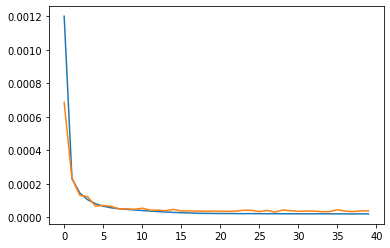

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

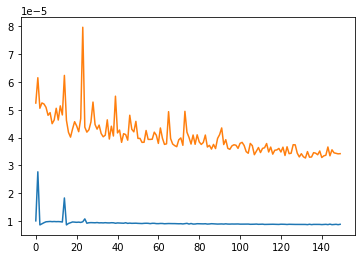

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss[50:])
plt.plot(val_loss[50:])

## Save model

In [ ]:
model_name = "ann_speed_13Mar_best"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

INFO:tensorflow:Assets written to: ram://42343e0a-d8a5-4253-b508-389af808afe0/assets


# Hyperparameters tuning

### Model Creation

In [ ]:
def create_dynamic_model(hp: kt.HyperParameters) -> Model:
    """
    Creates Sequence model dynamically
    :param hp: Hyper parameters (Initialized by a tuning algorithm)
    :return:
    """
    model = Sequential()
    model.add(layers.Input(shape=(hp.get("input_columns_amount"))))    

    dense_layers = hp.Int("dense_layers", min_value=1, max_value=4)
    for layer_id in range(dense_layers):
      layer_units = hp.Int(f"dense_{layer_id}_units", min_value=16, max_value=256, step=16)

      model.add(layers.Dense(layer_units, activation="tanh"))

      if hp.Boolean(f"dense_{layer_id}_dropout_status"):
          dropout_rate = hp.Float(f"dense_{layer_id}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
          model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hp.get("output_columns_amount")))

    learning_rate = hp.Choice("adam_learning_rate", [0.1, 0.05, 1e-2, 1e-3, 5e-3, 5e-4])

    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)

    model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model



### The Tuner



In [ ]:
hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_SEQUENCE_COLUMNS))
hp.Fixed("output_columns_amount", len(OUTPUT_SEQUENCE_COLUMNS))

project_name = "ann_12MarDay_speed3"
tuner = kt.BayesianOptimization(
    create_dynamic_model,
    hyperparameters=hp,
    objective="val_loss",
    max_trials=1000,
    directory=TUNERS_FOLDER_PATH,
    project_name=project_name,
    executions_per_trial = 1
)

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'input_columns_amount': 34,
 'output_columns_amount': 3,
 'units_left': 756,
 'dense_layers': 4,
 'dense_0_units': 192,
 'dense_0_dropout_status': False,
 'adam_learning_rate': 0.0005,
 'learning_rate_decay': False,
 'dense_0_dropout_rate': 0.4,
 'dense_1_units': 16,
 'dense_1_dropout_status': False,
 'dense_2_units': 16,
 'dense_2_dropout_status': False,
 'dense_3_units': 208,
 'dense_3_dropout_status': False,
 'dense_1_dropout_rate': 0.4,
 'dense_3_dropout_rate': 0.1,
 'dense_2_dropout_rate': 0.4}

In [ ]:
model = tuner.get_best_models()[0]
model_name = "speed_best_12Mar_10"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

INFO:tensorflow:Assets written to: ram://9003b5c1-8826-4d1b-812e-1558676a29db/assets


INFO:tensorflow:Assets written to: ram://9003b5c1-8826-4d1b-812e-1558676a29db/assets


### Truning

In [ ]:
tensorboard_dir = os.path.join(os.path.join(TUNERS_FOLDER_PATH,project_name), "tensorboard")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, 
                                                      histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, baseline= 0.01)

tuner.search(train_x,
            train_y,
             validation_data=(dev_x, dev_y),
             epochs = 2000,
             batch_size=512,
             callbacks=[early_stop, tensorboard_callback])

